### To classify songs into genres based on their features


#### 1. Prepare the Dataset


In [1]:
import pandas as pd

def fetch_echo_data():
    echonest = pd.read_json(r'.\datasets\echonest-metrics.json', orient='columns')
    rock_vs_hiphop = pd.read_csv(r'.\datasets\fma-rock-vs-hiphop.csv')
    echo_tracks = pd.merge(echonest, rock_vs_hiphop[['track_id', 'genre_top']], on='track_id')
    return echo_tracks

#### 2. Take a Quick Look at the Data Structure


In [3]:
tracks = fetch_echo_data()

In [4]:
tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [5]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [6]:
tracks.drop('track_id', axis=1).describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000
mean,4.870600e-01,0.436556,0.625126,0.604096,0.187997,0.104877,126.687944,0.453413
std,3.681396e-01,0.183502,0.244051,0.376487,0.150562,0.145934,34.002473,0.266632
min,9.491000e-07,0.051307,0.000279,0.000000,0.025297,0.023234,29.093000,0.014392
25%,8.351236e-02,0.296047,0.450757,0.164972,0.104052,0.036897,98.000750,0.224617
50%,5.156888e-01,0.419447,0.648374,0.808752,0.123080,0.049594,124.625500,0.446240
75%,8.555765e-01,0.565339,0.837016,0.915472,0.215151,0.088290,151.450000,0.666914
max,9.957965e-01,0.961871,0.999768,0.993134,0.971392,0.966177,250.059000,0.983649


In [7]:
tracks['genre_top'].value_counts()

genre_top
Rock       3892
Hip-Hop     910
Name: count, dtype: int64

We see that rock class is more than the other class. this may cause the model to be biased towards the rock class.


##### Plot a Histogram for each Numerical Attribute


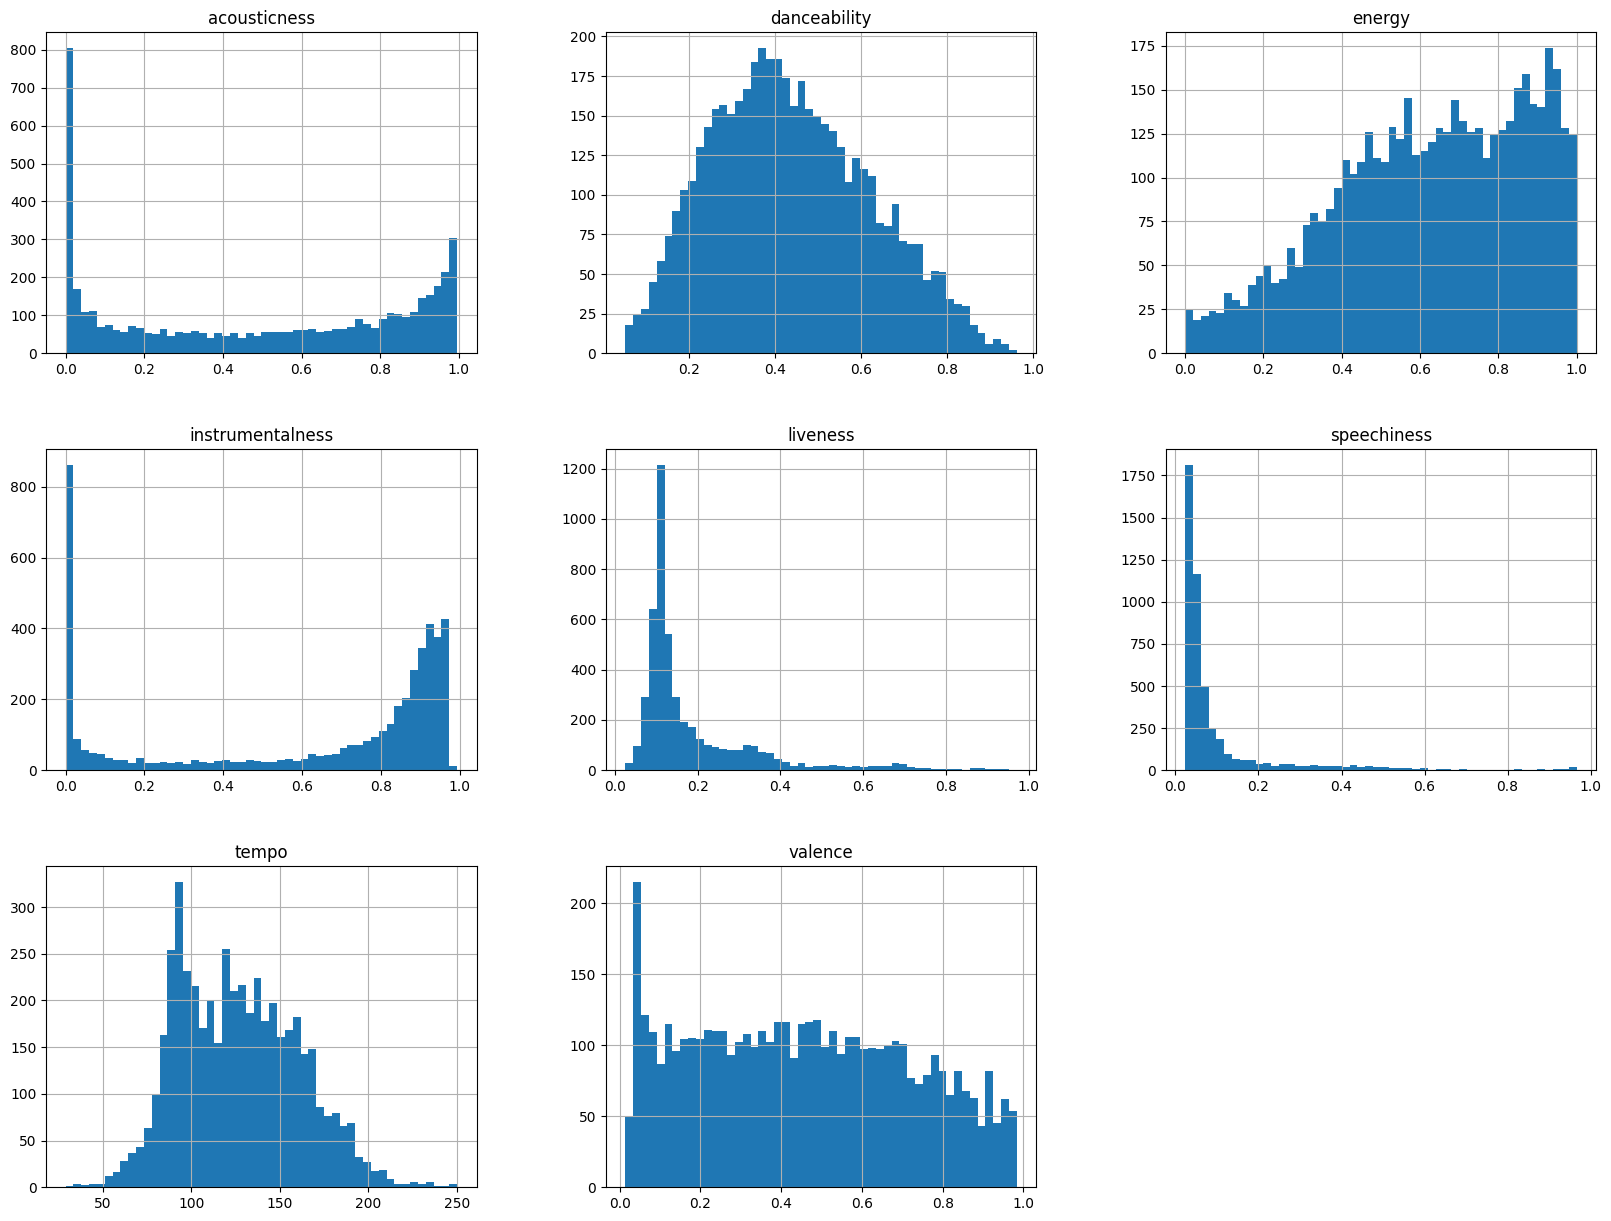

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
tracks.drop('track_id', axis=1).hist(bins=50, figsize=(20,15))
plt.show()

##### Notice a few thins in this histogram:

1. The _tempo_ feature has a different scale than the other features. This is a common issue with real-world data, and many algorithms don’t perform well when the input numerical attributes have very different scales.
2. many features are tail-heavy. Some extend far to the right of the median, some extend far to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns.


##### Pairwise Relationships between Continuous Variables


In [9]:
# Create a correlation matrix
corr_metrics = tracks.drop(['track_id', 'genre_top'], axis=1).corr()
corr_metrics.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
acousticness,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


We see that that not many features are correlated with each other. This is good in a way because it means that there is not much redundant or irrelevant information in our data.


#### 3. Prepare the Data for Machine Learning Algorithms


##### Create a Test Set


In [10]:
from sklearn.model_selection import train_test_split

# Create features
features = tracks.drop(['genre_top', 'track_id'], axis=1)

# Create labels
labels = tracks['genre_top']

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

##### Data cleaning


In [11]:
# Check for null entries
features.isnull().sum()

acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
dtype: int64

##### Feature scaling


In [12]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

##### Principal Component Analysis

PCA is a technique that finds the axes that account for the largest amount of variance in the training set. It is a powerful tool for dimensionality reduction. As our coorelation matrix shows that there is not much correlation between the features, we can use PCA to reduce the dimensionality of the dataset.


Text(0.5, 0, 'Principal Component')

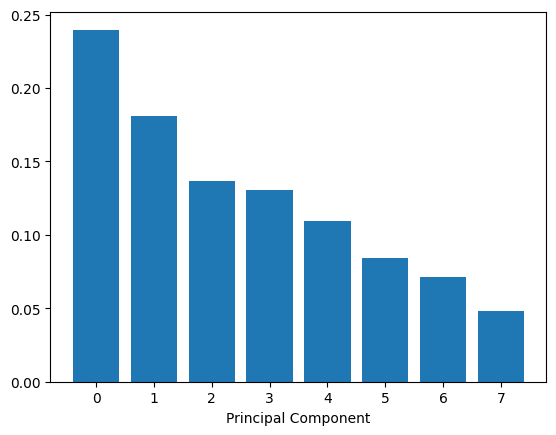

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(8), exp_variance)
ax.set_xlabel('Principal Component')

There does not appear to be a clear elbow in the plot. Now we can use **cumulative explained variance** to determine the number of components to keep.

CUMULATIVE EXPLAINED VARIANCE

- The explained variance tells us how much information (variance) can be attributed to each of the principal components. The explained variance is used to determine the number of principal components to keep. The cumulative explained variance tells us the total amount of variance we'd capture if we kept the first n principal components.


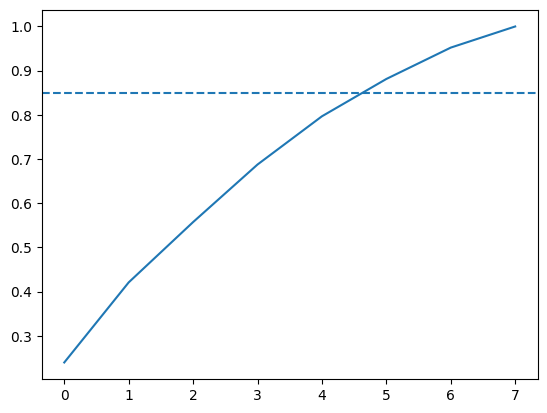

In [15]:
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
# here we are drawing a dashed line at 0.85, it means we are checking how many components we need to explain 85% of the variance
ax.axhline(y=0.85, linestyle='--')

We saw from the plot that 6 features (remember indexing starts at 0) can explain 85% of the variance!

Therefore, we can use 6 components to perform PCA and reduce the dimensionality of our train and test features.


In [17]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components=6, random_state=10)

# Fit and transform the scaled training features using pca
train_pca = pca.fit_transform(scaled_train_features)

# Fit and transform the scaled test features using pca
test_pca = pca.transform(scaled_test_features)

#### 4. Select and Train a Model


##### Training and Evaluating on the Training Set


In [18]:
from sklearn.tree import DecisionTreeClassifier

# Train our decision tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)

Evaluate the model using classification metrics such as accuracy, precision, recall, and F1 score.


In [19]:
# create classification report
from sklearn.metrics import classification_report

class_rep_tree = classification_report(test_labels, pred_labels_tree)

print("Decision Tree: \n", class_rep_tree)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.66      0.63      0.64       225
        Rock       0.91      0.92      0.92       976

    accuracy                           0.87      1201
   macro avg       0.79      0.78      0.78      1201
weighted avg       0.87      0.87      0.87      1201



Compare our decision tree to a logistic regression


In [20]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=42)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

Evaluate it


In [21]:
# create classification report
from sklearn.metrics import classification_report

class_rep_logit = classification_report(test_labels, pred_labels_logit)

print("Logistic Regression: \n", class_rep_logit)

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.54      0.64       225
        Rock       0.90      0.96      0.93       976

    accuracy                           0.89      1201
   macro avg       0.84      0.75      0.79      1201
weighted avg       0.88      0.89      0.88      1201



From these results we see that the model is indeed biased towards the rock class. This is because the rock class is the majority class in our dataset. We can try to balance the dataset by using the class_weight parameter in the DecisionTreeClassifier.


##### Balance our data for better performance


In [22]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = tracks.loc[tracks['genre_top'] == 'Hip-Hop']
rock_only = tracks.loc[tracks['genre_top'] == 'Rock']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1)
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

During balancing we have lost many data. Let's test the model again.

In [23]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.83      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



Using cross-validation to evaluate our models


In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree, train_pca, train_labels, cv=10)

# Print the accuracy for each fold
print("Scores: ", scores)
print("Mean: ", scores.mean())
print("Standard Deviation: ", scores.std())

Scores:  [0.76642336 0.8540146  0.82481752 0.77372263 0.80291971 0.80147059
 0.81617647 0.73529412 0.84558824 0.79411765]
Mean:  0.8014544869042508
Standard Deviation:  0.03449975066480958


In [25]:
scores = cross_val_score(logreg, train_pca, train_labels, cv=10)

# Print the accuracy for each fold
print("Scores: ", scores)
print("Mean: ", scores.mean())
print("Standard Deviation: ", scores.std())

Scores:  [0.79562044 0.83941606 0.84671533 0.80291971 0.74452555 0.83088235
 0.85294118 0.81617647 0.85294118 0.86764706]
Mean:  0.8249785315586088
Standard Deviation:  0.03463936511157637


In [2]:
print(str(print("hello"))+"one")

hello
Noneone
